# Motion Capture data

This dataset was taken from Reynolds, Zachs and Braver (2007) model of event segmentation. [[paper](https://www.ncbi.nlm.nih.gov/pubmed/21635310)] [[dataset/code]](https://wustl.app.box.com/s/0l0r2w2jg715cx567bli). The paper is worth reading butone of the main take away is that prediction errors are indicative of event boundaries, meaning that prediction errors are lower within an event than between them.

The data are 3d motion capture data of people moving. At each point in time, the position of the human in the recording is described by 18 points in (x, y, z) coordinate space. Motion is indicated by the updating of these points from timepoint to timepoint. There are 13 distinct events in the dataset and approximately 10 timepoints per event.

In [1]:
%matplotlib inline
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data_file = './datasets/motion_data.pkl'
motion_data = pd.read_pickle(data_file)
print "Number of events:", set(motion_data.EventNumber)
print "Timepoint / event:", len(motion_data) / float(len(set(motion_data.EventNumber)))

Number of events: set([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
Timepoint / event: 10.5384615385


Formally, each scence vector $s$ is a 54D vector of the 18 points in coordinate space and each event consistest of an ordered list of scene vectors. Below is a visualization of a single event in (x, y) coordinate space. Time is represented by color, with yellow indicating early in time and red later in time (such that each of the 18 points in (x, y) space at a particular moment in time is represented with the same color)

In [3]:
def plot_event(event_number):
    e = motion_data.loc[motion_data.EventNumber == event_number, :]
    cols = e.columns[:-1]
    e = e[cols].values

    cc = sns.color_palette("YlOrRd", n_colors=e.shape[0])
    for ii in range(e.shape[0]-1):
        for jj in range(18):
            plt.plot([e[ii, jj], e[ii+1, jj]], [e[ii, 18+jj], e[ii+1, 18+jj]],
                     color=cc[ii], marker='^', markersize=ii)
    plt.gca().set_xlabel('x-coordinate')
    plt.gca().set_ylabel('y-coordinate')

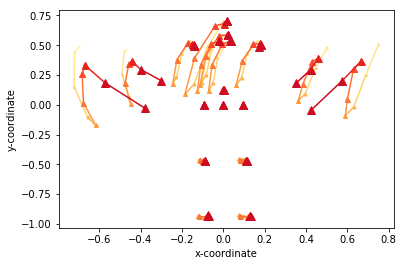

In [4]:
plot_event(1)

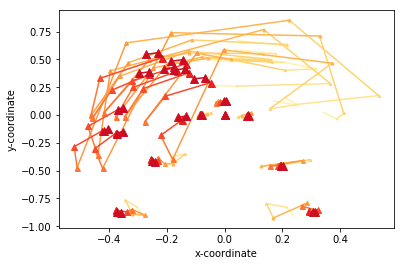

In [5]:
plot_event(8)

We can use these events generatively to create set of training data to evaluate the SEM model. To do so, we sample a random list of events and concetanate their scene vectors into a single vector:

$X = [s_1, s_2, ... , s_n]$

and create a corresponding vector of the event identities

$y = [e_i, e_i, ..., e_j]$

In [6]:
from opt.evaluate_motion import generate_random_events
X_train, y_train = generate_random_events(10, data_file=data_file)

Using TensorFlow backend.


We can the train the SEM model to predict $X_{t+1}|X_{1:t}$. We'll evaluate the model by plotting how well it predicts the event labels, using the adjusted [Rand Index](https://en.wikipedia.org/wiki/Rand_index) as our clustering measure.

Widget Javascript not detected.  It may not be installed or enabled properly.



Adjusted Rand Index: 0.272642121769


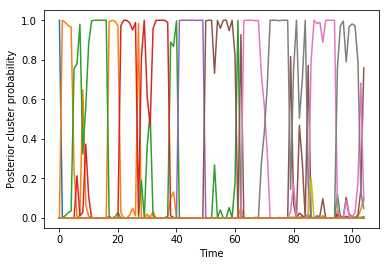

In [7]:
import tensorflow as tf
from models import SEM, KerasSRN_batch
from opt.evaluate_motion import evaluate

# options 
sgd_kwargs = {
    'nesterov': True, 
    'lr': 0.01, 
    'momentum': 0.9, 
    'decay': 0.001
}

_, D = X_train.shape

# specify the model architecture (makes a big difference! especially the training parameters)
f_class = KerasSRN_batch
f_opts = dict(t=2, n_batch=250, aug_noise=0.01, sgd_kwargs=sgd_kwargs,
             n_hidden1=D, n_hidden2=D, hidden_act1='relu', hidden_act2='relu',)

Omega = {
    'lmda': 50.0,
    'alfa': 0.25,
    'beta': 0.04, ## this parameter ends up being really important
    'f_class': f_class,
    'f_opts': f_opts
}
r, post = evaluate(X_train, y_train, Omega, save=False)
print "Adjusted Rand Index:", r
plt.plot(post)
plt.gca().set_ylabel('Posterior cluster probability')
plt.gca().set_xlabel('Time')
plt.show()
tf.Session().close()

That's not great, but it's above chance which is good enough for now.

For comparison, let's compare at the max posterior cluster to the true event labels are shown below (the colors are not consistent between the two due to label switching, which is not important)

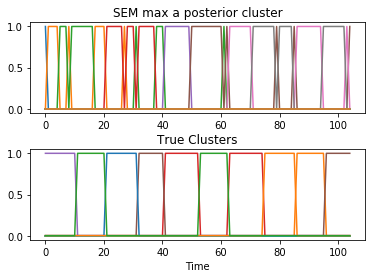

In [8]:
import numpy as np
fig, axes = plt.subplots(2, 1)

max_post = np.zeros(post.shape)
for t in range(post.shape[0]):
    max_post[t, :] = post[t, :] == post[t, :].max()
axes[0].plot(max_post)
axes[0].set_title('SEM max a posterior cluster')

y_clust = np.zeros((y_train.shape[0], 13))
for ii, y0 in enumerate(y_train):
    y_clust[ii, y0] = 1.0
axes[1].plot(y_clust)
axes[1].set_title('True Clusters')
axes[1].set_xlabel('Time')
plt.subplots_adjust(hspace=0.4)
plt.show()

How well does the NN model were using seperate between the events? Here, we train a NN for each event (i.e. conditioned on an event) and compare the mean squared error for each scene in that event vs the average mse on all of the other events. Sepearation between these lines (which may reflect overfitting) is necessary for a single event model to capture it's own dynamics while failing to capture the dynamics of the other events. 

This is highly similar to saying the within event prediction error (pe) should be lower than the between event (event boundary) pe.

Widget Javascript not detected.  It may not be installed or enabled properly.


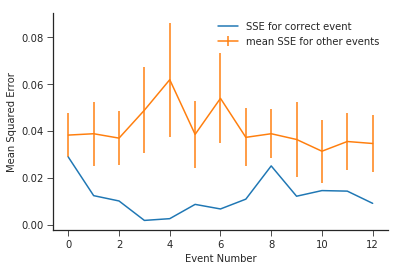

In [9]:
from sklearn.metrics import mean_squared_error
from tqdm import tnrange

p = 0
n_events = len(set(motion_data.EventNumber))

sse = np.zeros(n_events)
sse_cross = np.zeros((n_events, n_events-1))

def pull_event(event_number):
    e = motion_data.loc[motion_data.EventNumber == event_number, :]
    cols = e.columns[:-1]
    return e[cols].values

for p in tnrange(n_events):
    
    e = pull_event(p)
    
    # train a model with an event sequence, evaluate it's errors on other event sequences
    X = e[:-1]
    y = e[1:]

    N, D =  X.shape
    model = KerasSRN_batch(D, **f_opts)
    model.update(X, y)
    y_hat = model.predict(X)

    sse[p] = mean_squared_error(y, y_hat)


    events = range(n_events)
    events.remove(p)
    for t, p0 in enumerate(events):
        e0 = pull_event(p0)

        X0 = e0[:-1]
        y0 = e0[1:]
        y0_hat = model.predict(X0)
        sse_cross[p, t] = mean_squared_error(y0, y0_hat)


with sns.axes_style('ticks'):
    plt.plot(sse, label='SSE for correct event')

    x = range(n_events)
    y = np.mean(sse_cross, axis=1)
    y_err = np.std(sse_cross,  axis=1)
    plt.errorbar(x, y, y_err, label='mean SSE for other events')
    plt.legend()
    plt.gca().set_xlabel('Event Number')
    plt.gca().set_ylabel('Mean Squared Error')
    sns.despine()

    

# Event Model: Motion Dynamics
A simple question we can ask is what does the event model predict (by event model I mean the class of RNNs trained on a specific event type). Here is an RNN with the same parameters as above trained on a known event.

We run this generatively, initializing at the first point in the event & predicting the next scene in an event

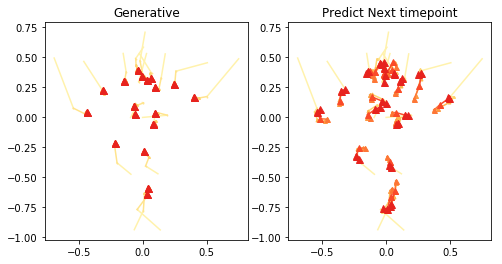

In [10]:
from models import KerasSRN_batch

e = motion_data.loc[motion_data.EventNumber == 1, :]
cols = e.columns[:-1]
e = e[cols].values
    
X = e[:-1, :]
y = e[1:, :]
srn = KerasSRN_batch(D, **f_opts)
srn.update(X, y)

def run_generative(model, X):
    X_gen = [np.reshape(X[0, :], (1, 54))]
    for ii in range(X.shape[0] -1):
        X_gen.append(model.predict(X_gen[-1]))
    X_gen = np.concatenate(X_gen)
    return X_gen

def predict(model, X):
    y_hat = [np.reshape(X[0, :], (1, 54))]
    for ii in range(X.shape[0] -1):
        y_hat.append(srn.predict(X[ii, :]))
    y_hat = np.concatenate(y_hat)
    return y_hat

def plot_time2d(X, ax):
    cc = sns.color_palette("YlOrRd", n_colors=e.shape[0])
    for ii in range(e.shape[0]-2):
        for jj in range(18):
            ax.plot([X[ii, jj], X[ii+1, jj]],
                     [X[ii, 18+jj], X[ii+1, 18+jj]],
                     color=cc[ii], marker='^', markersize=ii)
            

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

plot_time2d(run_generative(srn, X), axes[0])
plot_time2d(predict(srn, X), axes[1])

axes[0].set_title('Generative')
axes[1].set_title('Predict Next timepoint')